# JB2008 MSIS Comparisons

Compare the accuracy of JB2008 and MSIS at GRACE-B, CHAMP, and GOCE. 

Compare the accuracy when the models are shifted to GRACE-B in a simple normalization of the density profile. 

These are large files with sub minute cadence. To make the analysis managable we'll randomly select a subset of points.


In [24]:
%load_ext autoreload
%autoreload 2

#print all output in a cell 
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import os, sys

from pymsis import msis
from sklearn.metrics import median_absolute_error

jb_path = "D:\\GitHub\\jb2008\\jb08"
sys.path.append(os.path.dirname(jb_path))

import jb08

In [26]:
lat_d = 5
lon_d = 5

ch_d = r"D:\data\SatDensities\ch_den_profile.hdf"
go_d = r"D:\data\SatDensities\go_den_profile.hdf"
storm_txt = r'D:\GitHub\SatDrag\data\storms_drag_epochs_no_overlap.txt'

fi = ch_d
sat = fi.split('\\')[-1][0:2]

# read in the satellite data
dat = pd.read_hdf(fi)
dat =dat[(dat['del_lon'].abs() < lon_d) & (dat['del_lat'].abs() < lat_d)]

In [27]:
# get storm times
# read in storm start and end times

storm_time = pd.read_csv(storm_txt, header=None, skiprows=1, 
                     delim_whitespace=1, names = ['t_st','t_dst','t_en'], parse_dates=[0, 1, 2],
                     infer_datetime_format=True)

# loop through the storms and set
# flags in the satellite drag database
# for the different times

dat['storm'] = -1
dat['storm phase'] = -1

for index, row in storm_time.iterrows():
    stp = (dat[f'DateTime_{sat}']>=row['t_st']) & (dat[f'DateTime_{sat}']<row['t_en'])
    mpp = (dat[f'DateTime_{sat}']>=row['t_st']) & (dat[f'DateTime_{sat}']<row['t_dst'])
    rpp = (dat[f'DateTime_{sat}']>=row['t_dst']) & (dat[f'DateTime_{sat}']<row['t_en'])

    dat.loc[stp,'storm'] = 1
    dat.loc[mpp,'storm phase'] = 1
    dat.loc[rpp,'storm phase'] = 2

In [28]:
dat.head()
dat.shape

,DateTime_ch,alt_ch,lat_ch,lon_ch,dens_x_ch,DateTime_gr,alt_gr,lat_gr,lon_gr,dens_x_gr,del_lon,del_lat,del_lat_near,lat_gr_near,lon_gr_near,pos,storm,storm phase
DateTime_ch,,,,,,,,,,,,,,,,,,
2002-04-06 15:43:30,2002-04-06 15:43:30,437254.390,-87.055620,133.860137,3.862711e-12,2002-04-06 15:43:30,519073.037,-88.322,136.536,1.137365e-12,-2.675863,1.266380,-0.142380,-87.198,121.559,824098,-1,-1
2002-04-06 16:29:20,2002-04-06 16:29:20,408620.456,87.265805,-83.045802,4.874812e-12,2002-04-06 16:29:20,512400.493,82.639,-82.713,1.298829e-12,-0.332802,4.626805,-0.230805,87.035,70.002,824391,-1,-1
2002-04-13 02:09:00,2002-04-13 02:09:00,427704.318,-87.230417,-43.750844,3.888378e-12,2002-04-13 02:09:00,524230.624,-86.716,-45.165,1.096479e-12,1.414156,-0.514417,-0.069583,-87.300,96.298,879698,1,1
2002-04-13 02:09:40,2002-04-13 02:09:40,426744.588,-85.920458,-5.494757,3.654423e-12,2002-04-13 02:09:40,524956.885,-88.848,-5.225,1.110166e-12,-0.269757,2.927542,-0.180542,-86.101,102.866,879700,1,1
2002-04-16 06:34:40,2002-04-16 06:34:40,420582.760,87.236840,64.993346,5.705645e-12,2002-04-16 06:34:40,501880.807,87.071,67.051,2.021202e-12,-2.057654,0.165840,-0.165840,87.071,67.051,907203,1,2


(25392, 18)

## Get JB2008 Densities

In [29]:
jb_sat = jb08.jb2008(t=dat[f'DateTime_{sat}'].to_numpy(),
                     lat=dat[f'lat_{sat}'].to_numpy(), lon=dat[f'lon_{sat}'].to_numpy(), 
                     alt=dat[f'alt_{sat}'].to_numpy()/1000.)
jb_sat.predict()

jb_gr = jb08.jb2008(t=dat[f'DateTime_gr'].to_numpy(),
                     lat=dat[f'lat_gr'].to_numpy(), lon=dat[f'lon_gr'].to_numpy(), 
                     alt=dat[f'alt_gr'].to_numpy()/1000.)
jb_gr.predict()

Dask Apply:   0%|          | 0/65 [00:00<?, ?it/s]

Dask Apply:   0%|          | 0/65 [00:00<?, ?it/s]

## Get MSIS Densities

In [30]:
msis_sat = [
            msis.run(date,lon,lat,s_alt/1000.,geomagnetic_activity=-1*gs)[0,0] \
            for date, lat, lon, s_alt, gs, \
            in zip(dat[f'DateTime_{sat}'].to_numpy(), 
                   dat[f'lat_{sat}'].to_numpy(), 
                   dat[f'lon_{sat}'].to_numpy(), 
                   dat[f'alt_{sat}'].to_numpy(),
                   dat['storm'].to_numpy())
            ]

msis_gr = [
            msis.run(date,lon,lat,s_alt/1000.,geomagnetic_activity=-1*gs)[0,0] \
            for date, lat, lon, s_alt, gs, \
            in zip(dat[f'DateTime_gr'].to_numpy(), 
                   dat[f'lat_gr'].to_numpy(), 
                   dat[f'lon_gr'].to_numpy(), 
                   dat[f'alt_gr'].to_numpy(),
                   dat['storm'].to_numpy())
            ]

c:\Users\murph\miniconda3\envs\satdrag\lib\site-packages\pymsis\utils.py:232: UserWarning: There is data that was either interpolated or predicted (not observed), use at your own risk.
  warnings.warn(


In [31]:
dat = dat.reset_index(drop=True)
dat[f'msis_{sat}'] = msis_sat
dat[f'jb08_{sat}'] = jb_sat.dat['DEN']

dat[f'msis_r_{sat}'] = dat[f'dens_x_{sat}'] - dat[f'msis_{sat}']
dat[f'jb08_r_{sat}'] = dat[f'dens_x_{sat}'] - dat[f'jb08_{sat}']

dat['msis_gr'] = msis_gr
dat['jb08_gr'] = jb_gr.dat['DEN']

dat['msis_r_gr'] = dat['dens_x_gr'] - dat['msis_gr']
dat['jb08_r_gr'] = dat['dens_x_gr'] - dat['jb08_gr']

# Compute ratios and normalized/shifted data
dat['msis_norm'] = dat[f'dens_x_{sat}']*dat['dens_x_gr']/dat['msis_gr']
dat['jb08_norm'] = dat[f'dens_x_{sat}']*dat['dens_x_gr']/dat['jb08_gr']

dat['msis_r_norm'] = dat[f'dens_x_{sat}']-dat['msis_norm']
dat['jb08_r_norm'] = dat[f'dens_x_{sat}']-dat['jb08_norm']


st = dat['storm'] == 1

for df in [dat, dat[st], dat[~st]]:
    print(f'Grace')
    print('MSIS ',median_absolute_error(df['dens_x_gr'], df['msis_gr']))
    print('JB2008 ', median_absolute_error(df['dens_x_gr'], df['jb08_gr']))

    print(f'{sat}')
    print('MSIS ', median_absolute_error(df[f'dens_x_{sat}'], df[f'msis_{sat}']))
    print('JB2008 ', median_absolute_error(df[f'dens_x_{sat}'], df[f'jb08_{sat}']))

    print(f'{sat} Normalized')
    print('MSIS ', median_absolute_error(df[f'dens_x_{sat}'], df['msis_norm']))
    print('JB2008 ', median_absolute_error(df[f'dens_x_{sat}'], df['jb08_norm']))
    print('---------------')

Grace
MSIS  4.506472373830159e-14
JB2008  2.5876192347842634e-14
ch
MSIS  6.079878438581277e-13
JB2008  4.301542538692734e-13
ch Normalized
MSIS  4.666967847065091e-13
JB2008  3.5247887441285624e-13
---------------
Grace
MSIS  5.560034468978606e-14
JB2008  4.260517213227386e-14
ch
MSIS  4.61438914217426e-13
JB2008  4.4019855740676963e-13
ch Normalized
MSIS  4.08523784237964e-13
JB2008  3.5399074869833843e-13
---------------
Grace
MSIS  3.730564456727758e-14
JB2008  1.6666738757089823e-14
ch
MSIS  7.709554936644837e-13
JB2008  4.221372901769054e-13
ch Normalized
MSIS  5.327591857957258e-13
JB2008  3.502652135689451e-13
---------------


In [32]:
dat['storm']

0       -1
1       -1
2        1
3        1
4        1
        ..
25387   -1
25388   -1
25389   -1
25390   -1
25391   -1
Name: storm, Length: 25392, dtype: int64

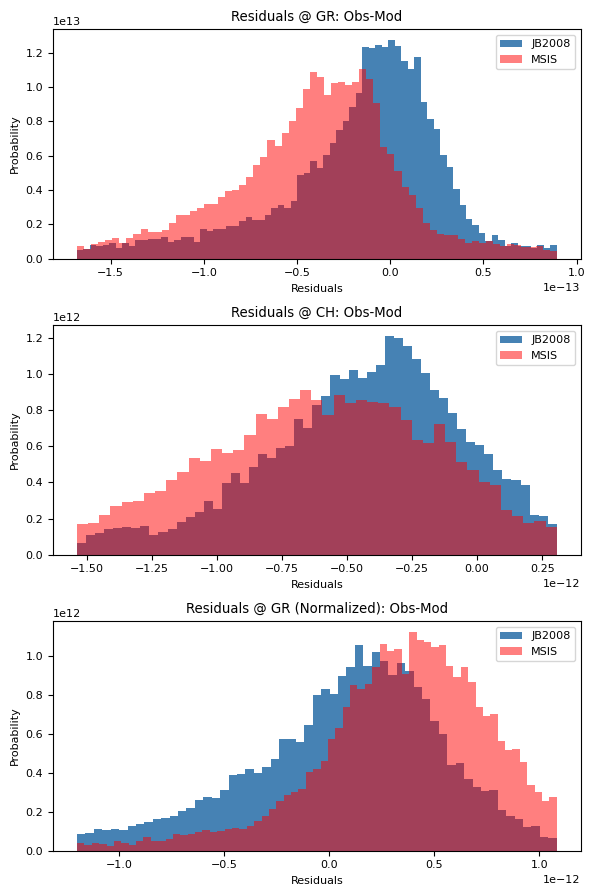

In [33]:
plt.rcParams.update({'font.size': 8})
fig, ax = plt.subplots(3,1, figsize=(6,9))
ax = ax.flatten()

density=True
lq=0.05
uq=0.95

# Grace Residuals
res_min = np.min([dat['msis_r_gr'].quantile(lq),dat['jb08_r_gr'].quantile(lq)])
res_max = np.max([dat['msis_r_gr'].quantile(uq),dat['jb08_r_gr'].quantile(uq)])

b_m = np.histogram_bin_edges(dat['msis_r_gr'],bins='fd', range=[res_min,res_max])
b_j = np.histogram_bin_edges(dat['jb08_r_gr'],bins='fd', range=[res_min,res_max])

_ = ax[0].hist(dat['jb08_r_gr'].to_numpy(),bins=b_j, alpha = 1,
                 label='JB2008', density=density, color='steelblue') 
_ = ax[0].hist(dat['msis_r_gr'].to_numpy(),bins=b_m, alpha = 0.5,
                 label='MSIS', density=density, color='red') 
_ = ax[0].legend(fontsize=8)
_ = ax[0].set(title='Residuals @ GR: Obs-Mod', xlabel='Residuals', 
          ylabel='Probability')

# Grace Residuals
res_min = np.min([dat[f'msis_r_{sat}'].quantile(lq),dat[f'jb08_r_{sat}'].quantile(lq)])
res_max = np.max([dat[f'msis_r_{sat}'].quantile(uq),dat[f'jb08_r_{sat}'].quantile(uq)])

b_m = np.histogram_bin_edges(dat[f'msis_r_{sat}'],bins='fd', range=[res_min,res_max])
b_j = np.histogram_bin_edges(dat[f'jb08_r_{sat}'],bins='fd', range=[res_min,res_max])

_ = ax[1].hist(dat[f'jb08_r_{sat}'].to_numpy(),bins=b_j, alpha = 1,
                 label='JB2008', density=density, color='steelblue') 
_ = ax[1].hist(dat[f'msis_r_{sat}'].to_numpy(),bins=b_m, alpha = 0.5,
                 label='MSIS', density=density, color='red') 
_ = ax[1].legend(fontsize=8)
_ = ax[1].set(title=f'Residuals @ {sat.upper()}: Obs-Mod', xlabel='Residuals', 
          ylabel='Probability')

# Grace Norm Residuals
res_min = np.min([dat['msis_r_norm'].quantile(lq),dat['jb08_r_norm'].quantile(lq)])
res_max = np.max([dat['msis_r_norm'].quantile(uq),dat['jb08_r_norm'].quantile(uq)])

b_m = np.histogram_bin_edges(dat['msis_r_norm'],bins='fd', range=[res_min,res_max])
b_j = np.histogram_bin_edges(dat['jb08_r_norm'],bins='fd', range=[res_min,res_max])

_ = ax[2].hist(dat['jb08_r_norm'].to_numpy(),bins=b_j, alpha = 1,
                 label='JB2008', density=density, color='steelblue') 
_ = ax[2].hist(dat['msis_r_norm'].to_numpy(),bins=b_m, alpha = 0.5,
                 label='MSIS', density=density, color='red') 
_ = ax[2].legend(fontsize=8)
_ = ax[2].set(title='Residuals @ GR (Normalized): Obs-Mod', xlabel='Residuals', 
          ylabel='Probability')

fig.tight_layout()